In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import sys
sys.path.append("src/")
import operator
from importlib import reload
import src.preprocessing.data_loading as data_loading
import models.experiment as experiment
import models.rnn as rnn
import analysis.umap_analysis as umap
import analysis.scatter_plots as scatter_plots
import analysis.evaluation as evaluation
from preprocessing.X_representation import RAA_to_seq
from preprocessing.X_representation_utils import initialize_Proc2Vec_embeddings
from utils.utils import find_3mer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
import analysis.shapley_additive_analysis as shapley
from analysis.hit_rate_analysis import (
    find_12ca5_motif,
    find_mdm2_motif,
    seq_contains_mdm2_motif,
    seq_contains_12ca5_motif,
)
from IPython.utils import io
from tqdm import tqdm

2023-02-16 10:57:41.519004: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-16 10:57:49.461142: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/ml_phage/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Train MDM2 vs. 12ca5 Model



In [4]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")

protein_of_interest = "MDM2"
other_protein = "12ca5"
(
    X,
    mdm2_y,
    mdm2_y_raw,
    ca5_y,
    ca5_y_raw,
    peptides,
    FEATURE_LIST,
) = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    aa_representations=[
        data_loading.AA_REPRESENTATION.PRO2VEC,
        data_loading.AA_REPRESENTATION.RAA,
        data_loading.AA_REPRESENTATION.PHYSIOCHEM_PROPERTIES,
        data_loading.AA_REPRESENTATION.ONE_HOT,
    ],
)


(
    (
        X_train,
        X_test,
        mdm2_y_train,
        mdm2_y_test,
        mdm2_y_raw_train,
        mdm2_y_raw_test,
        ca5_y_train,
        ca5_y_test,
        ca5_y_raw_train,
        ca5_y_raw_test,
        peptides_train,
        peptides_test,
    ),
    results,
) = experiment.BinaryClassificationExperiment().run_adhoc_experiment(
    X,
    mdm2_y,
    rnn.Joint_BinaryClassificationRNN_gelu,
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    load_trained_model=True,
    model_save_name='mdm2_bilstm_best.h5',
    other_datasets=[
        mdm2_y_raw,
        ca5_y,
        ca5_y_raw,
        peptides,
    ],
)
mdm2_model = results.trained_model
mdm2_y_pred_raw = mdm2_model(X_test)
mdm2_y_pred = mdm2_y_pred_raw > 0.5


def ca5_model(x):
    ca5_pred_raw = mdm2_model(x).numpy()
    ca5_pred_raw[:, 1] = 1 - ca5_pred_raw[:, 1]
    return ca5_pred_raw


ca5_y_pred_raw = ca5_model(X_test)
ca5_y_pred = ca5_y_pred_raw > 0.5

print("MDM2")
evaluation.classification_evaluation_joint(mdm2_y_test, mdm2_y_pred)
print("12ca5")
evaluation.classification_evaluation_joint(ca5_y_test, ca5_y_pred)

are we in here?


Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.


 - log P value cutoff is -0.44638568713238386, and log FC value cutoff is -0.6565247891915524
MDM2
P-VAL
	 accuracy:  0.7200364575421541
	 precision:  0.688961038961039
	 recall:  0.8868765672889384
	 # neg predictions:  1963
	 # pos predictions:  4620
Log Fold
	 accuracy:  0.8798420173173325
	 precision:  0.8765533028122956
	 recall:  0.9933296275708727
	 # neg predictions:  467
	 # pos predictions:  6116
12ca5
P-VAL
	 accuracy:  0.7200364575421541
	 precision:  0.688961038961039
	 recall:  0.8868765672889384
	 # neg predictions:  1963
	 # pos predictions:  4620
Log Fold
	 accuracy:  0.8798420173173325
	 precision:  0.9229122055674518
	 recall:  0.3634064080944351
	 # neg predictions:  6116
	 # pos predictions:  467


## Shapely Analysis 

In [71]:
from analysis.shapley_additive_analysis import shapley_analysis, INVESTIGATION_TYPE
from tqdm import tqdm

all_targets = list(zip(X, peptides))


def investigate_individual_peptides(
    peptide_seq,
    show_plot=True,
    num_background_samples=200,
    num_perturbation_samples=2000,
):
    print(
        f"{peptide_seq} is in the dataset as {mdm2_y_raw[[idx for idx, x in enumerate(peptides) if x == peptide_seq][0]]}"
    )
    attribution = shapley_analysis(
        mdm2_model,
        X,
        [x for x in all_targets if x[1] == peptide_seq],  # Known binder
        investigation_type=INVESTIGATION_TYPE.BY_AMINO_ACID,
        num_background_samples=num_background_samples,
        num_perturbation_samples=num_perturbation_samples,
        aa_feature_dim=len(FEATURE_LIST),
        show_plot=show_plot,
    )
    return attribution


In [72]:
def plot_aggregated_shap_values(
    aligned_peptides,
    residue_labels=["*", "F", "*", "*", "Hydrophobe", "Hydrophobe", "*"],
    title="Aggregated Shap Values over MDM2 Motif Containing Peptides",
    pickle_filename="mdm2_shap_value_comparison.pickle",
    left_boundary_increase=1,
    right_boundary_increase=1,
):
    residue_num = len(residue_labels)

    def define_range(
        match,
        array,
        blank,
    ):
        """
            We endevor to look at space before and after the match
            (to expand the analysis past just the motif)
            but this requires us gracefully handle when the motif is either
            at the beginning or end of the peptide.
        """
        left_of_motif_array = []
        for left_idx in range(-left_boundary_increase, 0):
            left_of_motif_array.append(
                blank if (match[0] + left_idx) < 0 else array[match[0] + left_idx]
            )

        right_of_motif_array = []
        for right_idx in range(0, right_boundary_increase):
            right_of_motif_array.append(
                blank
                if (match[1] + right_idx) >= len(array)
                else array[match[1] + right_idx]
            )
        return [
            *left_of_motif_array,
            *array[match[0] : match[1]],
            *right_of_motif_array,
        ]

    collected_shap_values = []
    for peptide_of_interest, match in tqdm(aligned_peptides):
        with io.capture_output() as captured:
            attribution = investigate_individual_peptides(
                peptide_seq=peptide_of_interest,
                show_plot=False,
                num_background_samples=100,
                num_perturbation_samples=1000,
            )
        collected_shap_values.append(
            (
                define_range(match, attribution, blank=0),
                define_range(match, peptide_of_interest, blank=" "),
            ),
        )

    # Matrix is the list (residue idx) of dictionaries (amino acids) of list (shap_values)
    matrix = []

    for residue_idx in range(residue_num):
        aa_to_shap_value_lookup = {}
        for shap_values, peptide_str in collected_shap_values:
            aa = peptide_str[residue_idx]
            if aa == " ":
                continue

            shap_val_per_aa = aa_to_shap_value_lookup.get(aa, [])
            shap_val_per_aa.append(shap_values[residue_idx])
            aa_to_shap_value_lookup[aa] = shap_val_per_aa
        matrix.append(aa_to_shap_value_lookup)

    import pickle

    with open(pickle_filename, "wb") as handle:
        pickle.dump(matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Time to plot
    aa_to_marker = {
        "C": ".",  # point marker
        "Q": ",",  # pixel marker
        "E": "o",  # circle marker
        "G": "v",  # triangle_down marker
        "H": "^",  # triangle_up marker
        "I": "<",  # triangle_left marker
        "L": ">",  # triangle_right marker
        "K": "1",  # tri_down marker
        "M": "2",  # tri_up marker
        "F": "3",  # tri_left marker
        "P": "4",  # tri_right marker
        "S": "s",  # square marker
        "T": "p",  # pentagon marker
        "W": "*",  # star marker
        "Y": "h",  # hexagon1 marker
        "V": "H",  # hexagon2 marker
        "D": "+",  # plus marker
        "A": "x",  # x marker
        "R": "D",  # diamond marker
        "N": "d",  # thin_diamond marker
    }
    NUM_COLORS = len(aa_to_marker)
    cm = plt.get_cmap("inferno")
    color = [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]

    aa_to_marker_and_color = {
        aa: (marker, color[idx])
        for idx, (aa, marker) in enumerate(aa_to_marker.items())
    }

    for residue_idx, aa_to_shap_value_lookup in enumerate(matrix):
        for aa, shap_vals in aa_to_shap_value_lookup.items():
            mean_shap = np.mean(shap_vals)
            std_dev_shap = np.std(shap_vals)
            marker, color = aa_to_marker_and_color[aa]
            plt.errorbar(
                x=residue_idx, y=mean_shap, yerr=std_dev_shap, fmt=marker, color=color
            )
            plt.text(residue_idx, mean_shap, " " + aa, horizontalalignment="left")

    plt.xticks(np.arange(0, residue_num, step=1))
    plt.xticks(np.arange(residue_num), residue_labels)
    plt.title(title)
    plt.ylabel("Shap Value \n(higher = MDM2 affinity, lower = 12ca5 affinity)")


100%|██████████| 820/820 [2:03:47<00:00,  9.06s/it]  


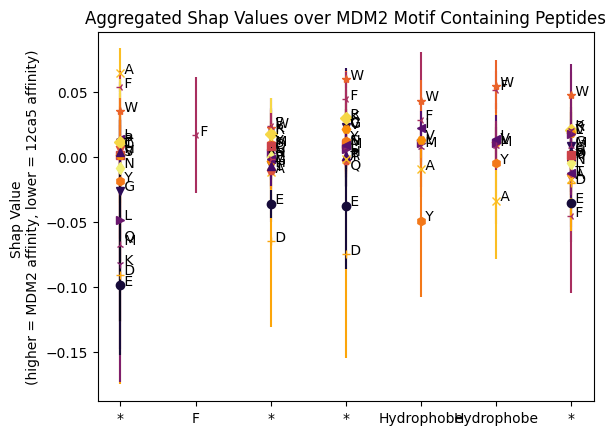

In [73]:
mdm2_motif_peptides = [
    (peptide, find_mdm2_motif(peptide).span())
    for peptide in peptides
    if seq_contains_mdm2_motif(peptide)
]
# # TODO: take off training wheels...
# mdm2_motif_peptides = mdm2_motif_peptides[:200]
plot_aggregated_shap_values(
    aligned_peptides=mdm2_motif_peptides,
    residue_labels=["*", "F", "*", "*", "Hydrophobe", "Hydrophobe", "*"],
    title='Aggregated Shap Values over MDM2 Motif Containing Peptides',
    pickle_filename='mdm2_shap_value_comparison.pickle'
)

In [75]:
ca5_motif_peptides = [
    (peptide, find_12ca5_motif(peptide).span())
    for peptide in peptides
    if seq_contains_12ca5_motif(peptide)
]
plot_aggregated_shap_values(
    aligned_peptides=ca5_motif_peptides,
    residue_labels=["*", "*", "*", "*", "D", "Y", "A/S", "*"],
    title="Aggregated Shap Values over 12ca5 Motif Containing Peptides",
    pickle_filename="12ca5_shap_value_comparison.pickle",
    left_boundary_increase=4,
    right_boundary_increase=1,
)


  0%|          | 0/1003 [01:53<?, ?it/s]


: 

AFCDYLCNV is in the dataset as [-0.35365716  0.56028434]


7/7 [==============================] - 1s 25ms/step


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


12500/12500 [==============================] - 1877s 150ms/step
Expected value:  0.38900594858190746 shapely value sum  0.13705302329995894
Model eval:  tf.Tensor([0.5260589], shape=(1,), dtype=float32)
Does this match the sum of shapely values + expected value (\Sum(phi_i) + phi_0)?  0.5260589718818665


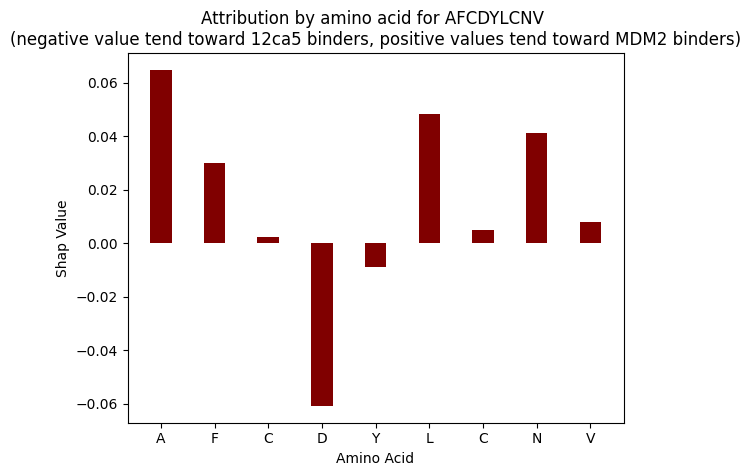

array([ 0.06483491,  0.03010083,  0.00230647, -0.06088268, -0.00890372,
        0.04838498,  0.0047965 ,  0.04128533,  0.00790991])

In [ ]:
investigate_individual_peptides("AFCDYLCNV")

AFCDWFWSS is in the dataset as [-0.20840332  1.35132244]


7/7 [==============================] - 1s 23ms/step


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


12500/12500 [==============================] - 97s 8ms/step
Expected value:  0.38900594858190746 shapely value sum  0.3270340070340899
Model eval:  tf.Tensor([0.71603996], shape=(1,), dtype=float32)
Does this match the sum of shapely values + expected value (\Sum(phi_i) + phi_0)?  0.7160399556159973


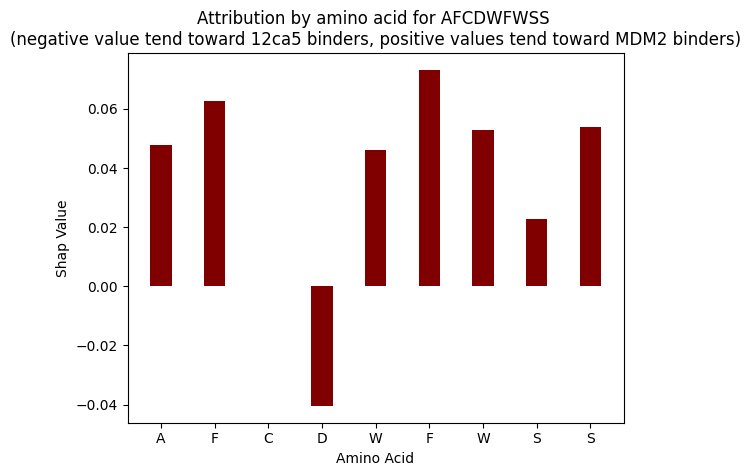

array([ 4.78001814e-02,  6.25372652e-02, -6.78124329e-05, -4.04737286e-02,
        4.60770729e-02,  7.31985525e-02,  5.30263584e-02,  2.26422294e-02,
        5.38363622e-02])

In [ ]:
investigate_individual_peptides("AFCDWFWSS")

AFCYLFWCS is in the dataset as [-0.19984816  0.92012466]


7/7 [==============================] - 0s 3ms/step


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


12500/12500 [==============================] - 43s 3ms/step
Expected value:  0.38900594858190746 shapely value sum  0.3269966945264605
Model eval:  tf.Tensor([0.7160027], shape=(1,), dtype=float32)
Does this match the sum of shapely values + expected value (\Sum(phi_i) + phi_0)?  0.7160026431083679


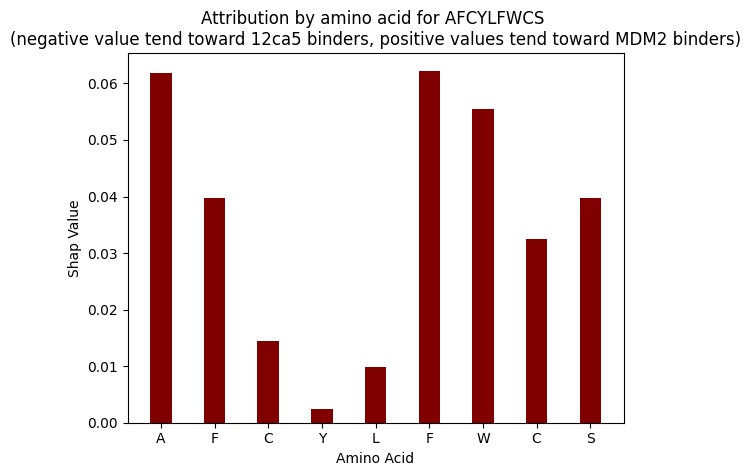

array([0.06177398, 0.03969148, 0.01448785, 0.00251039, 0.00993713,
       0.06224506, 0.05540809, 0.03255297, 0.0397848 ])

In [ ]:
investigate_individual_peptides("AFCYLFWCS") 


In [ ]:
investigate_individual_peptides("ACVSFSCWW") 


ACVSFSCWW is in the dataset as [-0.28294845  0.56028434]


7/7 [==============================] - 0s 4ms/step


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


 3936/12500 [========>.....................] - ETA: 30s

KeyboardInterrupt: 

ACERFACWW is in the dataset as [-0.49148452  0.30492372]


7/7 [==============================] - 0s 3ms/step


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


12500/12500 [==============================] - 27s 2ms/step
Expected value:  0.38900594858190746 shapely value sum  0.24763889165857111
Model eval:  tf.Tensor([0.63664496], shape=(1,), dtype=float32)
Does this match the sum of shapely values + expected value (\Sum(phi_i) + phi_0)?  0.6366448402404785


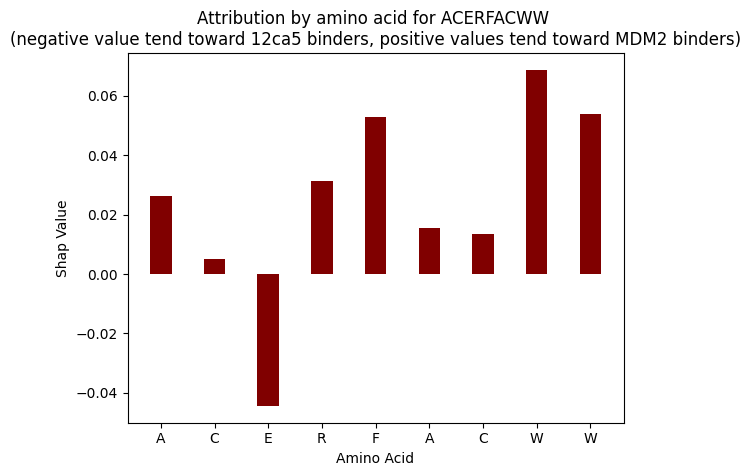

array([ 0.02627583,  0.00499396, -0.04438422,  0.03142755,  0.05293279,
        0.01546484,  0.01354928,  0.06868917,  0.05369013])

In [ ]:
investigate_individual_peptides("ACERFACWW") 


ACVDYAACR is in the dataset as [ 1.50397841 -1.72464401]


7/7 [==============================] - 0s 3ms/step


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


12500/12500 [==============================] - 26s 2ms/step
Expected value:  0.38900594858190746 shapely value sum  -0.36770563645026405
Model eval:  tf.Tensor([0.02130032], shape=(1,), dtype=float32)
Does this match the sum of shapely values + expected value (\Sum(phi_i) + phi_0)?  0.021300312131643406


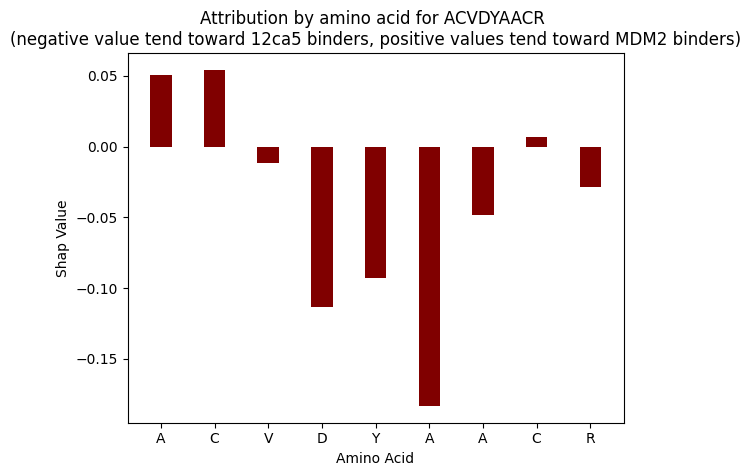

array([ 0.05035699,  0.05429087, -0.01145373, -0.11352226, -0.09271367,
       -0.18337989, -0.04807464,  0.00706425, -0.02826378])

In [ ]:
investigate_individual_peptides("ACVDYAACR")

AICRGDYAC is in the dataset as [ 4.64522306 -3.43722074]


7/7 [==============================] - 0s 3ms/step


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


12500/12500 [==============================] - 26s 2ms/step
Expected value:  0.38900594858190746 shapely value sum  -0.3871674706714111
Model eval:  tf.Tensor([0.00183848], shape=(1,), dtype=float32)
Does this match the sum of shapely values + expected value (\Sum(phi_i) + phi_0)?  0.00183847791049635


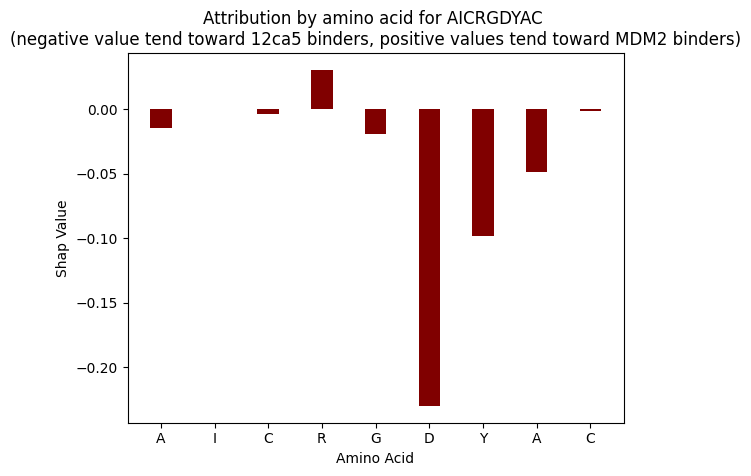

array([-0.01474103,  0.        , -0.00361006,  0.03030326, -0.0195799 ,
       -0.22999405, -0.09818041, -0.04868889, -0.00179982])

In [ ]:
investigate_individual_peptides("AICRGDYAC")

DYPDYAE is in the dataset as [ 4.26791951 -3.2639108 ]


7/7 [==============================] - 0s 5ms/step


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


12500/12500 [==============================] - 26s 2ms/step
Expected value:  0.38900594858190746 shapely value sum  -0.3838149847250316
Model eval:  tf.Tensor([0.00519097], shape=(1,), dtype=float32)
Does this match the sum of shapely values + expected value (\Sum(phi_i) + phi_0)?  0.005190963856875841


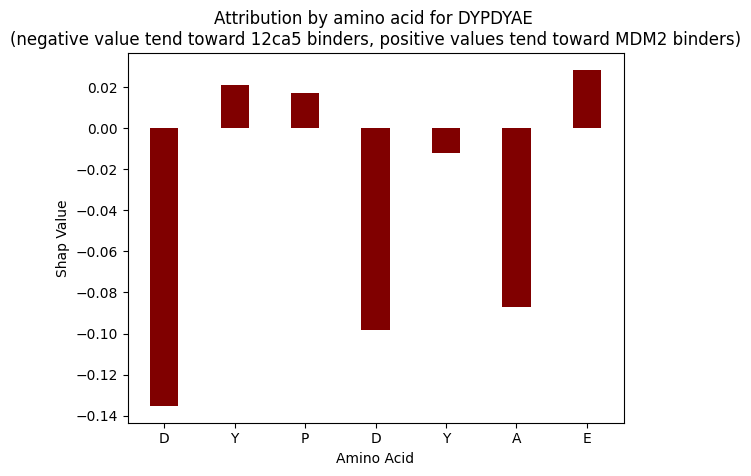

array([-0.13524835,  0.02107346,  0.01711827, -0.09814989, -0.01191789,
       -0.08690602,  0.02833052])

In [ ]:
investigate_individual_peptides("DYPDYAE")

IndexError: list index out of range

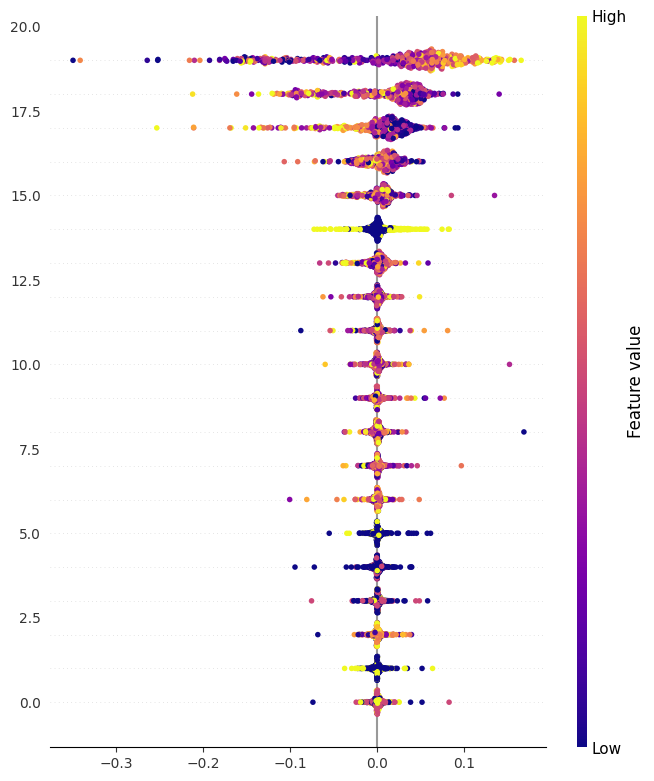

In [ ]:
from analysis.shapley_additive_analysis import shapley_analysis, INVESTIGATION_TYPE

investigation_target = all_targets[:50]
with io.capture_output() as captured:
    shapley_analysis(
        mdm2_model,
        X,
        investigation_target, 
        investigation_type=INVESTIGATION_TYPE.BY_FEATURE,
        aa_feature_dim=len(FEATURE_LIST)
    )